In [1]:
import pandas as pd
from evaluations.evaluation_data.evaluation_data import EvaluationData
from tampering.tampering import Tampering
from timf.timf import TIMF
from data_service.data_service import DataService
import numpy as np


evaluation_data = EvaluationData()
tampering = Tampering()
        
data_service = DataService()
timf = TIMF(data_service)

data = evaluation_data.get_data()


tampering_percentages = list(range(10, 100, 10))

tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated
# tampering_types = ["N"]
        
results = []

def _haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c

Loaded existing evaluation data from CSV.


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


results_metrics = []


for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:
        print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")
        for assessing_mic in data['gen_microcell'].unique():
            df_microcell = data[data['gen_microcell'] == assessing_mic]
            # print(df_microcell)

            bma_tampered_df = tampering.bma_tampering(
                        data[data['gen_microcell'] != assessing_mic].reset_index(drop=True),
                        tampering_percentage,
                        tampering_type
                    )
            
            

            remote_data = bma_tampered_df.copy()

            # Replicate data: for each provider in df_microcell, pull records from 10 nearest microcells
            microcell_coords = data.groupby('gen_microcell')[['latitude', 'longitude']].first().reset_index()
            current_coords = microcell_coords[microcell_coords['gen_microcell'] == assessing_mic]
            if not current_coords.empty:
                lat1 = current_coords['latitude'].values[0]
                lon1 = current_coords['longitude'].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, 'currect_microcell'] = assessing_mic
                
                # df_microcell['currect_microcell'] = assessing_mic
                replicated_parts = [df_microcell_part]
                for provider_id in df_microcell['providerid'].unique():
                    candidate_microcells = []
                    provider_remote = remote_data[remote_data['providerid'] == provider_id]
                    for _, row in microcell_coords.iterrows():
                        if row['gen_microcell'] == assessing_mic:
                            continue
                        if (provider_remote['gen_microcell'] == row['gen_microcell']).any():
                            dist = _haversine_km(lat1, lon1, row['latitude'], row['longitude'])
                            candidate_microcells.append((row['gen_microcell'], dist))

                    if candidate_microcells:
                        candidate_microcells.sort(key=lambda x: x[1])
                        nearby_microcells = [m for m, _ in candidate_microcells[:10]]
                    else:
                        nearby_microcells = []

                    if nearby_microcells:
                        remote_mask = (
                            (remote_data['providerid'] == provider_id) &
                            (remote_data['gen_microcell'].isin(nearby_microcells)) &
                            (remote_data['gen_microcell'] != assessing_mic)
                        )
                        df_remote = remote_data.loc[remote_mask].copy()
                        if not df_remote.empty:
                            df_remote = df_remote.drop_duplicates(subset='serviceid')
                            df_remote['origin'] = 'R'
                            df_remote['currect_microcell'] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            #df_microcell_replicated contain local generated data, and data gathered from 10 remte microcells per provider now lets assume the lacal super provider is also tamper with the data. 

            spa_tampered_df = tampering.spa_tampering(
                        df_microcell_replicated,
                        type=tampering_type
                    )
            
            # if assessing_mic=='M102':
            #     print(spa_tampered_df['currect_microcell'].unique())

            #     spa_tampered_df.to_csv("test.csv",index=False)
            #     bma_tampered_df.to_csv("test2.csv",index=False)

                

            #     print(df_microcell_replicated['gen_microcell'].unique())
            # else:
            #     continue


            
            data_service.set_local_data(spa_tampered_df.copy())
            # data_service.set_remote_data(bma_tampered_df.copy())
            data_service.set_remote_data(data[data['gen_microcell'] != assessing_mic].copy())
            

            # data service is set with the tamperedcx data which will be received by the timf

            # for each provider lets evaluate the trust score
            for provider in df_microcell['providerid'].unique():
                       
                trust_score, df = timf.trust_assessment(provider, assessing_mic)
                if not df.empty and 'true_label' in df.columns and 'label' in df.columns:
                    y_true = df['true_label']
                    y_pred = df['label']
                        
                        # Binary: T = 1 (tampered), C = 0 (correct)
                    y_true_bin = (y_true == 'T').astype(int)
                    y_pred_bin = (y_pred == 'T').astype(int)
                        
                    tp = ((y_true_bin == 1) & (y_pred_bin == 1)).sum()
                    fp = ((y_true_bin == 0) & (y_pred_bin == 1)).sum()
                    tn = ((y_true_bin == 0) & (y_pred_bin == 0)).sum()
                    fn = ((y_true_bin == 1) & (y_pred_bin == 0)).sum()
                        
                    total = len(y_true_bin)
                    accuracy = (tp + tn) / total if total > 0 else 0.0
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

                    results_metrics.append({
                            'tampering_type': tampering_type,
                            'tampering_percentage': tampering_percentage,
                            'microcell': assessing_mic,
                            'provider_id': provider,
                            'method': 'TDA',
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall': recall
                        })
                else:
                    print("issue with df for metrics calculation")
                    results_metrics.append({
                            'tampering_type': tampering_type,
                            'tampering_percentage': tampering_percentage,
                            'microcell': assessing_mic,
                            'provider_id': provider,
                            'method': 'TDA',
                            'accuracy': None,
                            'precision': None,
                            'recall': None
                        })
                
                baseline_results = timf.trust_assessment_baseline(provider, assessing_mic)
    

                for method_name, df_baseline in baseline_results.items():
                    if not df_baseline.empty and 'true_label' in df_baseline.columns and 'label' in df_baseline.columns:
                        y_true = (df_baseline['true_label'] == 'T').astype(int)  # 1 = tampered, 0 = correct
                        y_pred = (df_baseline['label'] == 'T').astype(int)

                        accuracy = accuracy_score(y_true, y_pred)
                        precision = precision_score(y_true, y_pred, zero_division=0)
                        recall = recall_score(y_true, y_pred, zero_division=0)

                        results_metrics.append({
                            'tampering_type': tampering_type,
                            'tampering_percentage': tampering_percentage,
                            'microcell': assessing_mic,
                            'provider_id': provider,
                            'method': method_name,  # specify which baseline
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall': recall
                        })
                    else:
                        # fallback if df is empty or missing columns
                        results_metrics.append({
                            'tampering_type': tampering_type,
                            'tampering_percentage': tampering_percentage,
                            'microcell': assessing_mic,
                            'provider_id': provider,
                            'method': method_name,
                            'accuracy': None,
                            'precision': None,
                            'recall': None
                        })


          

Experiment: Tampering Type=N, Percentage=10%
Experiment: Tampering Type=N, Percentage=20%
Experiment: Tampering Type=N, Percentage=30%
Experiment: Tampering Type=N, Percentage=40%
Experiment: Tampering Type=N, Percentage=50%
Experiment: Tampering Type=N, Percentage=60%
Experiment: Tampering Type=N, Percentage=70%
Experiment: Tampering Type=N, Percentage=80%
Experiment: Tampering Type=N, Percentage=90%
Experiment: Tampering Type=K, Percentage=10%
Experiment: Tampering Type=K, Percentage=20%
Experiment: Tampering Type=K, Percentage=30%
Experiment: Tampering Type=K, Percentage=40%
Experiment: Tampering Type=K, Percentage=50%
Experiment: Tampering Type=K, Percentage=60%
Experiment: Tampering Type=K, Percentage=70%
Experiment: Tampering Type=K, Percentage=80%
Experiment: Tampering Type=K, Percentage=90%
Experiment: Tampering Type=S, Percentage=10%
Experiment: Tampering Type=S, Percentage=20%
Experiment: Tampering Type=S, Percentage=30%
Experiment: Tampering Type=S, Percentage=40%
Experiment

In [ ]:
results_metrics

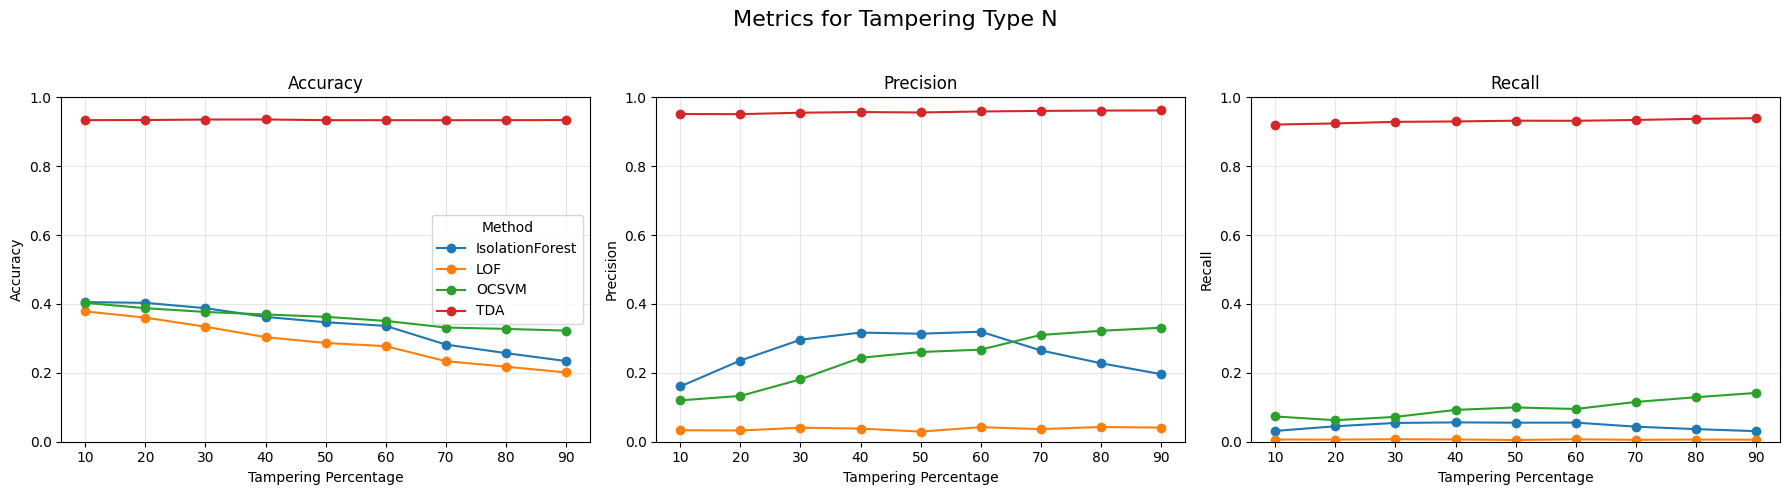

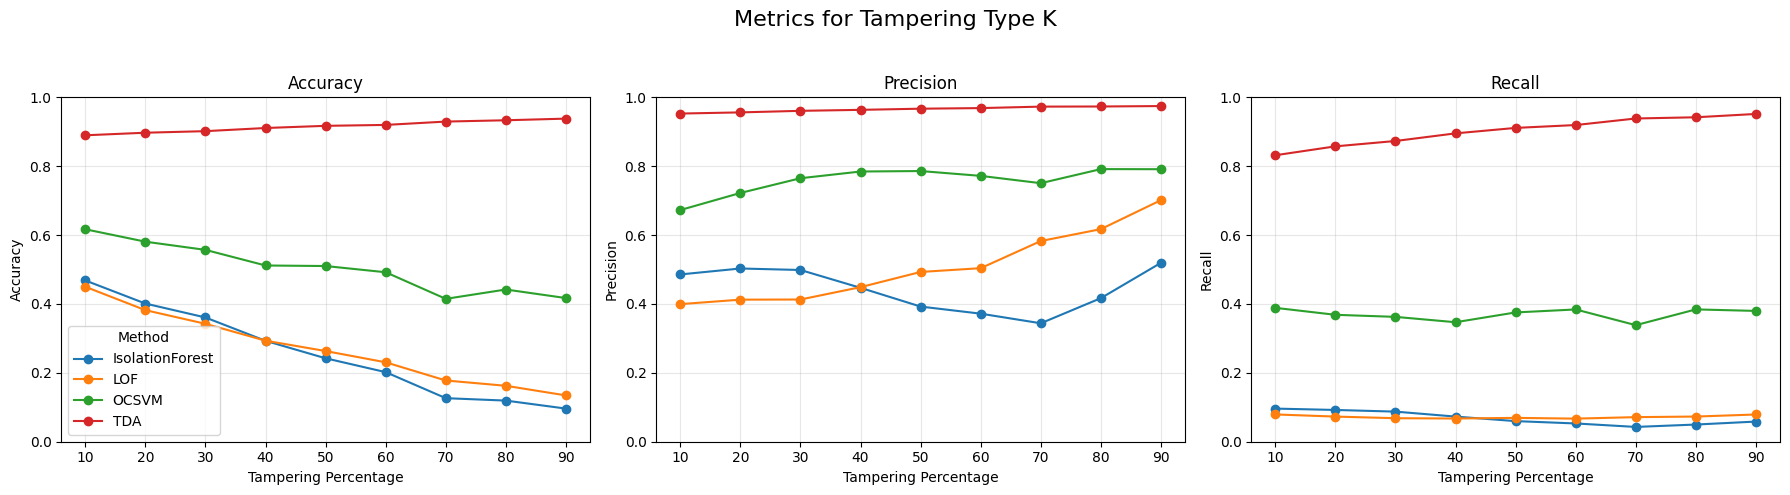

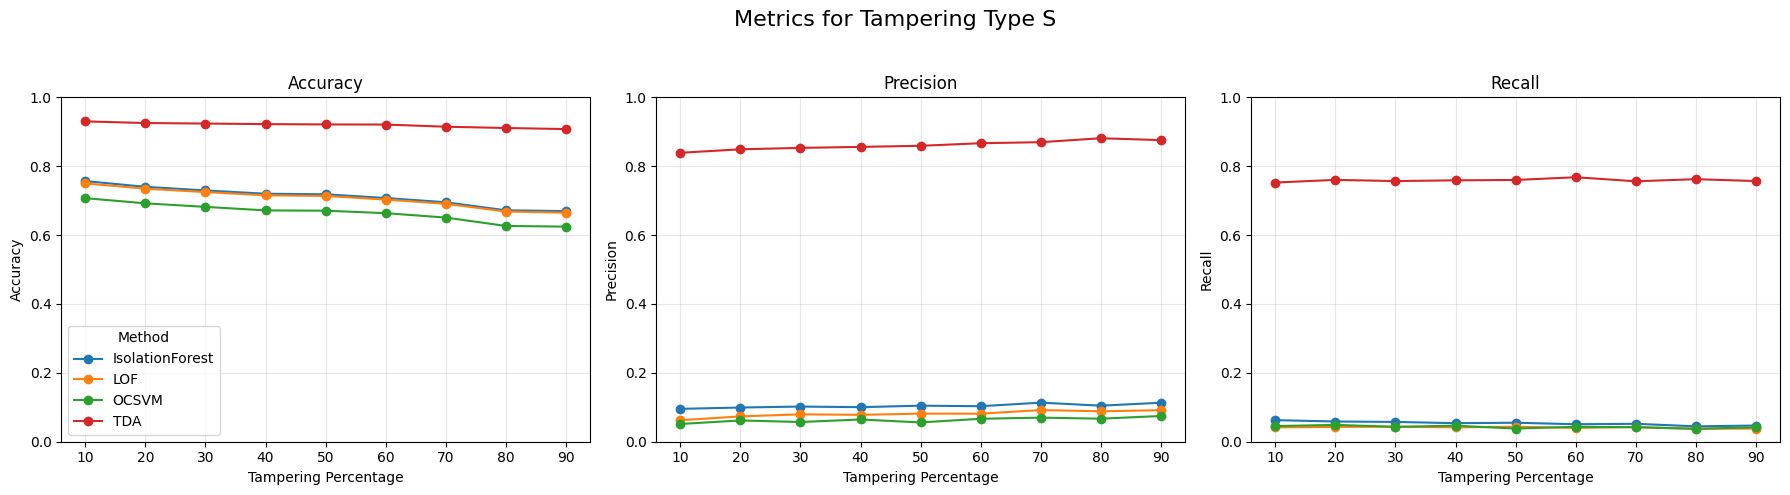

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the DataFrame
metrics_df = pd.DataFrame(results_metrics).dropna(subset=['accuracy','precision','recall'])

# Compute mean metrics per tampering_type, percentage, and method
summary = metrics_df.groupby(['tampering_type','tampering_percentage','method'], as_index=False)[['accuracy','precision','recall']].mean()

tampering_types = ["N","K","S"]
metric_names = ['accuracy', 'precision', 'recall']

# Loop over each tampering type
for t_type in tampering_types:
    subset_type = summary[summary['tampering_type'] == t_type]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    fig.suptitle(f'Metrics for Tampering Type {t_type}', fontsize=16)
    
    for idx, metric in enumerate(metric_names):
        ax = axes[idx]
        for method in subset_type['method'].unique():
            subset_method = subset_type[subset_type['method'] == method]
            ax.plot(subset_method['tampering_percentage'], subset_method[metric], marker='o', label=method)
        ax.set_title(metric.capitalize())
        ax.set_xlabel('Tampering Percentage')
        ax.set_ylabel(metric.capitalize())
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
    
    axes[0].legend(title='Method')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
metrics_df = pd.DataFrame(results_metrics).dropna(subset=['accuracy','precision','recall'])
summary = metrics_df.groupby(['tampering_type','tampering_percentage'], as_index=False)[['accuracy','precision','recall']].mean()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
metric_names = ['accuracy', 'precision', 'recall']

for idx, metric in enumerate(metric_names):
    ax = axes[idx]
    for t_type in tampering_types:
        subset = summary[summary['tampering_type'] == t_type]
        ax.plot(subset['tampering_percentage'], subset[metric], marker='o', label=t_type)
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Tampering Percentage')
    ax.set_ylabel(metric.capitalize())
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

axes[0].legend(title='Type')
plt.tight_layout()
plt.show()

summary

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Setup for Paper Quality
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.dpi': 300
})

# Use a colorblind-friendly style
plt.style.use('tableau-colorblind10')

# 2. Data Preparation
metrics_df = pd.DataFrame(results_metrics).dropna(subset=['accuracy','precision','recall'])
summary = metrics_df.groupby(['tampering_type','tampering_percentage'], as_index=False)[['accuracy','precision','recall']].mean()
tampering_types = summary['tampering_type'].unique()

# 3. Define distinctive markers and line styles
markers = ['o', 's', '^', 'D', 'v', 'p', 'X']
linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (5, 10))]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)
metric_names = ['accuracy', 'precision', 'recall']

for idx, metric in enumerate(metric_names):
    ax = axes[idx]
    for i, t_type in enumerate(tampering_types):
        subset = summary[summary['tampering_type'] == t_type]
        ax.plot(
            subset['tampering_percentage'], 
            subset[metric], 
            label=t_type,
            marker=markers[i % len(markers)], 
            linestyle=linestyles[i % len(linestyles)],
            linewidth=2,
            markersize=7,
            alpha=0.85
        )
    
    # Aesthetic adjustments
    ax.set_title(metric.capitalize(), fontweight='bold', pad=10)
    ax.set_xlabel('Tampering Percentage')
    if idx == 0:
        ax.set_ylabel('Score')
    
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# 4. Centralized Legend below the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05),
           ncol=len(tampering_types), frameon=False, title='Tampering Method')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('integrity_metrics_results.pdf', bbox_inches='tight') # PDF is best for LaTeX
plt.show()

In [ ]:
data

In [ ]:
data.to_csv('experiment_1_original_data.csv', index=False)

In [ ]:
"""
Evaluation framework for Trust Information Management Framework (TIMF).

This module provides controlled experiments to evaluate TIMF under various
tampering scenarios in a crowdsourced IoT environment.
"""




class Evaluations:
    def __init__(self):
        self.evaluation_data = EvaluationData()
        self.tampering = Tampering()
        
        # Initialize DataService and TIMF properly
        self.data_service = DataService()
        self.timf = TIMF(self.data_service)

    def setup_experments(self):
      
        self.data = self.evaluation_data.get_data()
        print("Experment setup is complete.")
        
    def experiment_1(self, tampering_percentages=None, tampering_types=None):
        """
        Run experiment 1: Evaluate TIMF under controlled tampering scenarios.
        
        This experiment:
        - Applies synthetic tampering to data
        - Varies tampering percentage and type
        - Runs trust assessment for each provider in each microcell
        - Records results
        
        Args:
            tampering_percentages: List of percentages to test (default: 10 to 90 in steps of 10)
            tampering_types: List of tampering types ["N", "K", "S"] (default: all)
        
        Returns:
            results: Dictionary with experiment results
        """
        if tampering_percentages is None:
            tampering_percentages = list(range(10, 100, 10))
        if tampering_types is None:
            tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated
        
        results = []
        
        
        untampered_data = self.data.copy()
        
        for tampering_type in tampering_types:
            for tampering_percentage in tampering_percentages:
                print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")
        
             

                # For each provider in each microcell, run trust assessment
                for microcell in self.data['microcell'].unique():
                    df_microcell = self.data[self.data['microcell'] == microcell]
                    # print(f"\nMicrocell: {microcell}")

                    # --- Per-microcell tampering setup ---
                    local_key = str(microcell)

              
                    spa_tampered_dict = self.tampering.spa_tampering(
                        self.data[self.data['microcell'] == microcell],
                        sp_percent=100,              # always tamper the local microcell
                        type=tampering_type
                    )

                    bma_tampered_df = self.tampering.bma_tampering(
                        self.data[self.data['microcell'] != microcell],
                        tampering_percentage,
                        tampering_type
                    )
                   
               
                    # Set tampered and untampered data directly in data service
                    self.data_service.set_tampered_data(spa_tampered_dict,bma_tampered_df)
                

                    # --- Trust assessment for all providers in this local microcell ---
                    for provider in df_microcell['providerid'].unique():
                       
                        trust_score, df = self.timf.trust_assessment(provider, microcell)
                        
                        # Calculate accuracy, precision, and recall by comparing true_label and label
                        
                        metrics = self._calculate_metrics(df['true_label'], df['label'])
                            
                        result = {
                                'tampering_type': tampering_type,
                                'tampering_percentage': tampering_percentage,
                                'microcell': microcell,
                                'provider_id': provider,
                                'trust_score': trust_score,
                                'accuracy': metrics['accuracy'],
                                'precision': metrics['precision'],
                                'recall': metrics['recall']
                            }
                        results.append(result)
                            
                        # print(f"  Provider: {provider} -> Trust score: {trust_score:.4f}, "
                        #           f"Accuracy: {metrics['accuracy']:.4f}, "
                        #           f"Precision: {metrics['precision']:.4f}, "
                        #           f"Recall: {metrics['recall']:.4f}")
                        
        print(results)
        # Convert results to DataFrame for analysis
        results_df = pd.DataFrame(results)
        return results_df
    
    def _calculate_metrics(self, y_true, y_pred):
        """
        Calculate accuracy, precision, and recall metrics.
        
        Args:
            y_true: Series with true labels ('C' for Correct, 'T' for Tampered)
            y_pred: Series with predicted labels ('C' for Correct, 'T' for Tampered)
            
        Returns:
            Dictionary with accuracy, precision, and recall
        """
        # Convert to binary: 'T' = 1 (positive), 'C' = 0 (negative)
        y_true_binary = (y_true == 'T').astype(int)
        y_pred_binary = (y_pred == 'T').astype(int)
        
        # Calculate True Positives, False Positives, True Negatives, False Negatives
        tp = ((y_true_binary == 1) & (y_pred_binary == 1)).sum()
        fp = ((y_true_binary == 0) & (y_pred_binary == 1)).sum()
        tn = ((y_true_binary == 0) & (y_pred_binary == 0)).sum()
        fn = ((y_true_binary == 1) & (y_pred_binary == 0)).sum()
        
        # Calculate metrics
        total = len(y_true)
        accuracy = (tp + tn) / total if total > 0 else 0.0
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall
        }




                
    










    def _dictionary_to_merged_df(self,dic):
        temp = pd.concat(dic.values(), ignore_index=True)
        temp.reset_index(drop=True, inplace=True)
        return temp

    def _dataframe_divide_to_microcell_dictionary(self, df):
        """
        Divide a DataFrame into a dictionary keyed by microcell.
        
        Args:
            df: DataFrame with 'microcell' column
            
        Returns:
            Dictionary with microcell as key, DataFrame as value
        """
        temp_dictionary = {}
        unique_keys = df.microcell.unique()
        for microcell in unique_keys:
            temp_dictionary[str(microcell)] = df[df.microcell == microcell].copy()
        return temp_dictionary
      



        # Run experiment 1
       



#
# dfin = general.open_file_csv('data_alg_16000.csv')
# dfin = general.slice_df(dfin,['serviceid','providerid','microcell','timestamp','speed','latency','bandwidth','coverage','reliability','security','currect_microcell'])